In [2]:
!echo "Last updated: `date`"

Last updated: Fri Aug 14 08:50:18 PDT 2020


## [GP for binary classification (in STAN)][1]

$$
\begin{eqnarray}
y_n \mid p_i &\sim& \text{Bernoulli}(p_n), \text{ for } n=1,\dots, N \\
\text{logit}(\mathbf{p}) &\sim& \text{MvNormal}(0, K) \\
\alpha &\sim& \text{LogNormal}(0, 1) \\
\rho &\sim& \text{LogNormal}(0, 1) \\
\end{eqnarray}
%
$$

Try:
- adding a mean?

Note: 
- $\mathbf{K}$ is an $N\times N$ covariance matrix
  $K_{n,m} = \exp\left(-{\left\lVert\mathbf{x}_n - \mathbf{x}_m\right\rVert}^2_2\big/\rho^{2}\right)$.
- $\mathbf{x}_n$ are observed (possibly multivariate) spatial locations.

[1]: https://mc-stan.org/docs/2_24/stan-users-guide/fit-gp-section.html

In [3]:
# Load libraries.
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import pystan
from tqdm import trange
from scipy.spatial import distance_matrix
from scipy.stats import norm

import sys
sys.path.append('../util')
from pystan_vb_extract import pystan_vb_extract

*** 
Below are some helpers for plotting and generating data / grids.

In [4]:
def gen_grid(X, n, return_each=False, eps=0):
    x0, x1 = np.meshgrid(np.linspace(X[:, 0].min()-eps, X[:, 0].max()+eps, n),
                         np.linspace(X[:, 1].min()-eps, X[:, 1].max()+eps, n))
    
    Y = np.stack([x0.ravel(), x1.ravel()], axis=-1)
    
    if return_each:
        return Y, x0, x1
    else:
        return Y

In [5]:
def plot_data(X, y, edgecolors=None):
    colors = np.array(['blue', 'red'])
    plt.scatter(X[:, 0], X[:, 1], color=colors[y], edgecolors=edgecolors)
    
def plot_knots(W, color='grey', **kwargs):
    plt.scatter(W[:, 0], W[:, 1], color=color, marker='x', **kwargs)

In [132]:
def sqexp_cov_fn(d, rho, alpha):
    return alpha ** 2 * np.exp(-0.5 * (d / rho) ** 2)

def gp_predict_maker(y, x, x_new):
    N = x.shape[0]
    N_new = x_new.shape[0]
    M = N + N_new
    xx = np.concatenate((x_new, x), axis=0)
    D = distance_matrix(xx, xx)
    
    # Function which takes parameters of covariance function
    # and predicts at new locations.
    def gp_predict(rho, alpha, beta, sigma=1e-3):
        K = sqexp_cov_fn(D, rho, alpha) + np.eye(M) * np.power(sigma, 2)
        K_new_old = K[:N_new, N_new:]
        K_old_inv = np.linalg.inv(K[N_new:, N_new:])
        C = K_new_old.dot(K_old_inv)
        mu = beta + C.dot(y - beta)
        S = K[:N_new, :N_new] - C.dot(K_new_old.T)
        return np.random.multivariate_normal(mu, S)
    
    return gp_predict

In [33]:
# Data dictionary.
def create_stan_data(X, y, m_rho=0, s_rho=1, m_alpha=0, s_alpha=1, eps=1e-6):
    N, P = X.shape
    assert (N, ) == y.shape
    
    return dict(y=y, X=X, N=N, P=P,
                m_rho=m_rho, s_rho=s_rho,
                m_alpha=m_alpha, s_alpha=s_alpha, eps=eps)

In [9]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def plot_uq(post_samples, X, y, W, algo, n_new=1000, eps=0.2, figsize=(10, 8),
            color_res=100, color_res_sd=100, return_stuff=False, data_edgecolors=None,
            vmin_sd=0, vmax_sd=None):
    nsamples = post_samples['z'].shape[0]
    
    gp_predict, X_new, x0, x1 = make_gp_predict(X, W, eps=eps, n_new=n_new)
    
    preds = np.stack([gp_predict(post_samples['z'][i, :],
                                 post_samples['rho'][i])
                      for i in trange(nsamples)]) 
    
    plt.figure(figsize=figsize)
    
    # Plot mean function.
    plt.subplot(2, 2, 1)
    plt.contourf(x0, x1, sigmoid(preds).mean(0).reshape(x0.shape),
                 color_res,
                 cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
    plt.colorbar();
    plot_knots(W, color='black')
    plot_data(X, y, edgecolors=data_edgecolors);
    plt.xticks([]); plt.yticks([]);
    plt.title("Posterior Mean Function ({})".format(algo))
    
    # Plot function sd.
    plt.subplot(2, 2, 2)
    plt.contourf(x0, x1, sigmoid(preds).std(0).reshape(x0.shape),
                 color_res_sd, cmap=plt.get_cmap('Oranges'),
                 vmin=vmin_sd, vmax=vmax_sd)
    plt.colorbar();
    plot_knots(W, color='black')
    # plt.scatter(X[:, 0], X[:, 1], color='grey'); 
    plot_data(X, y)
    plt.xticks([]);
    plt.yticks([]);    
    plt.title("Posterior Standard Deviation Function ({})".format(algo))
    
    # Plot histogram of rho.
    plt.subplot(2, 2, 3)
    plt.hist(post_samples['rho'], bins=30, density=True);
    plt.title(r"Histogram of $\rho$ ({})".format(algo));
    plt.xlabel(r"$\rho$");
    plt.ylabel("density");
    
    if return_stuff:
        return X_new, preds

***

In [10]:
# Set random seed for reproducibility.
np.random.seed(1)

In [130]:
# Process convolution model.
model_code = """
data {
  int<lower=0> N;
  int<lower=0> P;
  int<lower=0, upper=1> y[N];
  matrix[N, P] X;
  real m_rho;
  real<lower=0> s_rho;
  real m_alpha;
  real<lower=0> s_alpha;
  real<lower=0> eps;
}

parameters {
  real<lower=0> rho;   // range parameter in GP covariance fn
  real<lower=0> alpha; // covariance scale parameter in GP covariance fn
  vector[N] eta;
  real beta;
}

transformed parameters {
  vector[N] f;
  {
    matrix[N, N] K;   // GP covariance matrix
    matrix[N, N] LK;  // cholesky of GP covariance matrix
    row_vector[N] row_x[N];
    
    // Using exponential quadratic covariance function
    for (n in 1:N) {
      row_x[n] = to_row_vector(X[n, :]);
    }
    K = cov_exp_quad(row_x, alpha, rho); 

    // Add small values along diagonal elements for numerical stability.
    for (n in 1:N) {
        K[n, n] = K[n, n] + eps;
    }

    // Cholesky of K (lower triangle).  
    LK = cholesky_decompose(K); 
  
    f = LK * eta;
  }
}

model {
  // Priors.
  alpha ~ lognormal(m_alpha, s_alpha);
  rho ~ lognormal(m_rho, s_rho);
  eta ~ std_normal();
  beta ~ std_normal();
 
  // Model.
  y ~ bernoulli_logit(beta + f);
}
"""

In [131]:
# Compile model. This takes about a minute.
%time sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f3f15ebdf199b89422e925a69ba6a344 NOW.


CPU times: user 976 ms, sys: 34.1 ms, total: 1.01 s
Wall time: 57.4 s


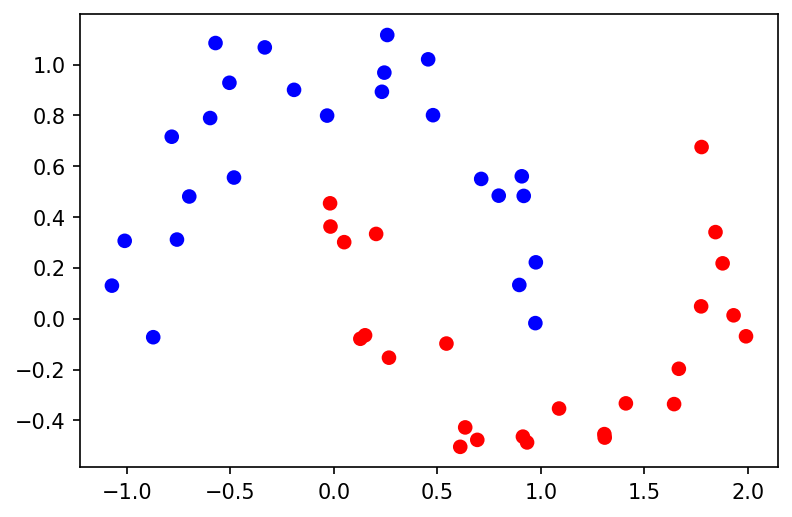

In [26]:
# Read data.
path_to_data = '../data/gp-binary-data-N50.json'
simdata = json.load(open(path_to_data))

# Store data.
X = np.stack([simdata['x1'], simdata['x2']], axis=-1)
y = np.array(simdata['y'])

# Plot data.
plot_data(X, y)

In [34]:
# Generate stan data dictionary.
stan_data = create_stan_data(X, y)

In [186]:
# Fit via ADVI.
%time vb_fit = sm.vb(data=stan_data, iter=1000, seed=1, grad_samples=1, elbo_samples=1)
vb_samples = pystan_vb_extract(vb_fit)

CPU times: user 395 ms, sys: 7.26 ms, total: 402 ms
Wall time: 398 ms


In [199]:
f = vb_samples["f"]
X_new, x0, x1 = gen_grid(X, 30, return_each=True, eps=0.5)
def gen_p_post(i):
    gp_predict = gp_predict_maker(f[i,:], X, X_new)
    return gp_predict(rho=vb_samples["rho"][i],
                      alpha=vb_samples["alpha"][i],
                      beta=vb_samples["beta"][i])

# %time p = np.stack([gen_p_post(i) for i in trange(1000)])
%time p = np.stack([gen_p_post(i) for i in trange(0, 1000, 10)])

100%|██████████| 100/100 [00:43<00:00,  2.28it/s]

CPU times: user 2min 5s, sys: 46.1 s, total: 2min 51s
Wall time: 43.9 s


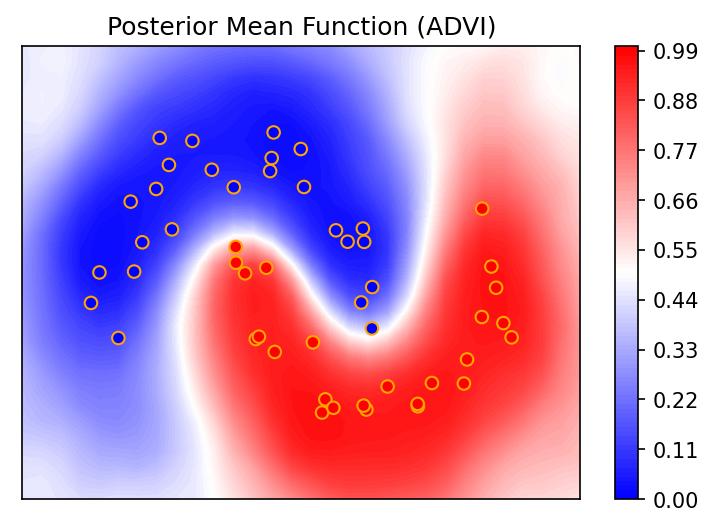

In [200]:
plt.contourf(x0, x1, sigmoid(p).mean(0).reshape(x0.shape),
             np.linspace(0, 1, 101),
             cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
plt.colorbar();
plot_data(X, y, edgecolors='orange');
plt.xticks([]); plt.yticks([]);
plt.title("Posterior Mean Function ({})".format('ADVI'));

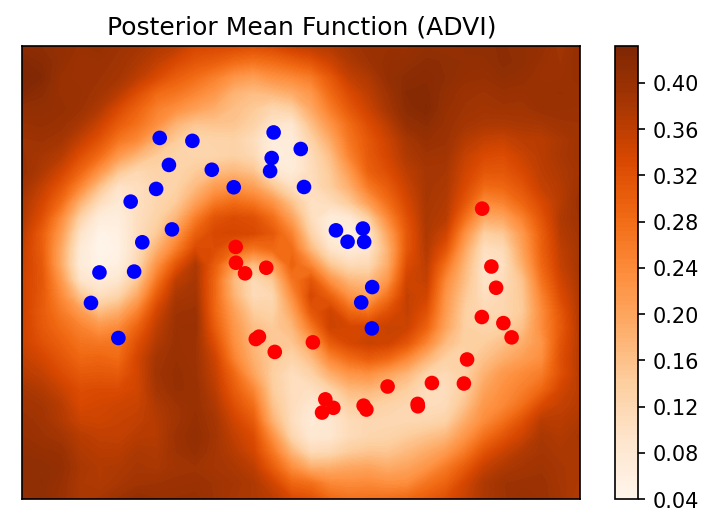

In [201]:
plt.contourf(x0, x1, sigmoid(p).std(0).reshape(x0.shape),
             101, # np.linspace(0, 0.5, 101), vmin=0, vmax=0.5,
             cmap=plt.get_cmap('Oranges'))
plt.colorbar();
plot_data(X, y)
plt.xticks([]); plt.yticks([]);
plt.title("Posterior Mean Function ({})".format('ADVI'));

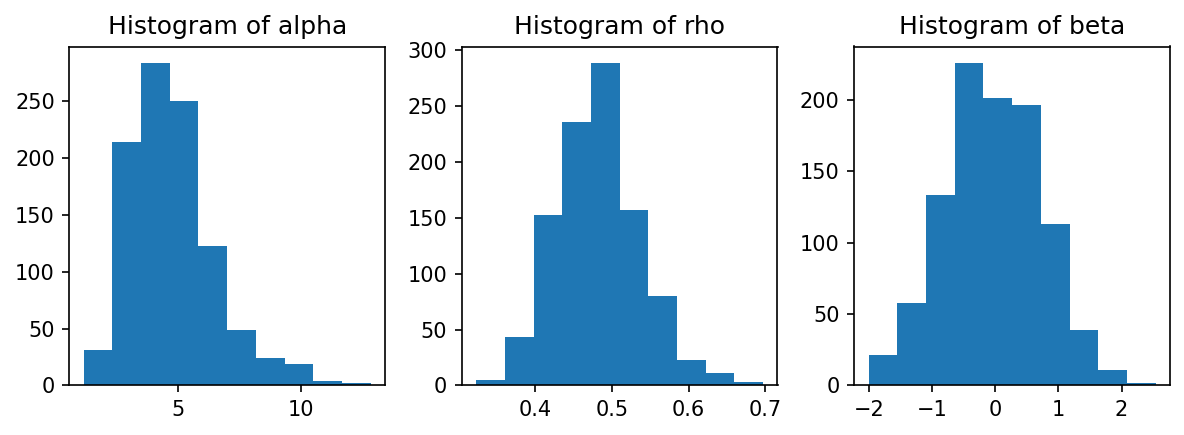

In [202]:
plt.figure(figsize=(8,3))
params = ['alpha', 'rho', 'beta']
for i in range(3):
    param = params[i]
    plt.subplot(1, 3, i+1)
    plt.hist(vb_samples[param]); plt.title('Histogram of {}'.format(param))
plt.tight_layout()

In [217]:
%%time

# Fit via HMC.
hmc_fit = sm.sampling(data=stan_data, iter=500, warmup=300, thin=1,
                      seed=1, algorithm='HMC', chains=1,
                      control=dict(stepsize=0.05, int_time=1, adapt_engaged=False))
                      # control=dict(stepsize=0.01, int_time=1, adapt_engaged=False))

CPU times: user 1.9 s, sys: 5.18 ms, total: 1.91 s
Wall time: 1.89 s


In [218]:
def gen_p_post(i):
    gp_predict = gp_predict_maker(hmc_fit['f'][i,:], X, X_new)
    return gp_predict(rho=hmc_fit["rho"][i],
                      alpha=hmc_fit["alpha"][i],
                      beta=hmc_fit["beta"][i])

# %time p = np.stack([gen_p_post(i) for i in trange(1000)])
%time p = np.stack([gen_p_post(i) for i in trange(0, 200, 2)])

100%|██████████| 100/100 [00:42<00:00,  2.33it/s]

CPU times: user 2min 1s, sys: 45.9 s, total: 2min 47s
Wall time: 43 s


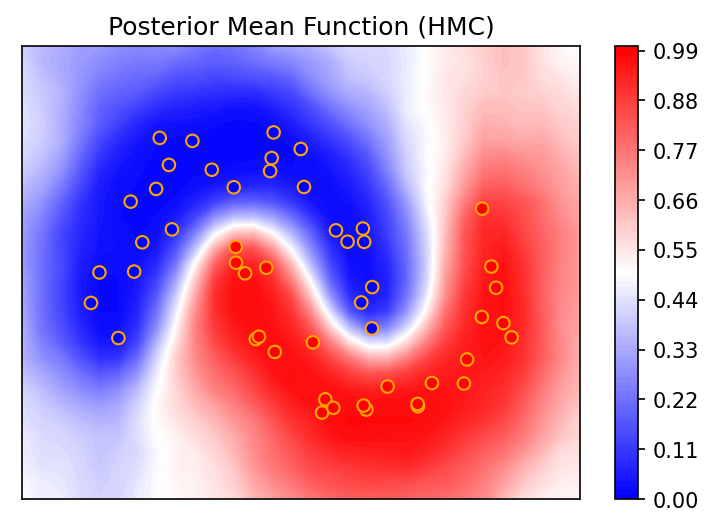

In [219]:
plt.contourf(x0, x1, sigmoid(p).mean(0).reshape(x0.shape),
             np.linspace(0, 1, 101),
             cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
plt.colorbar();
plot_data(X, y, edgecolors='orange');
plt.xticks([]); plt.yticks([]);
plt.title("Posterior Mean Function ({})".format('HMC'));

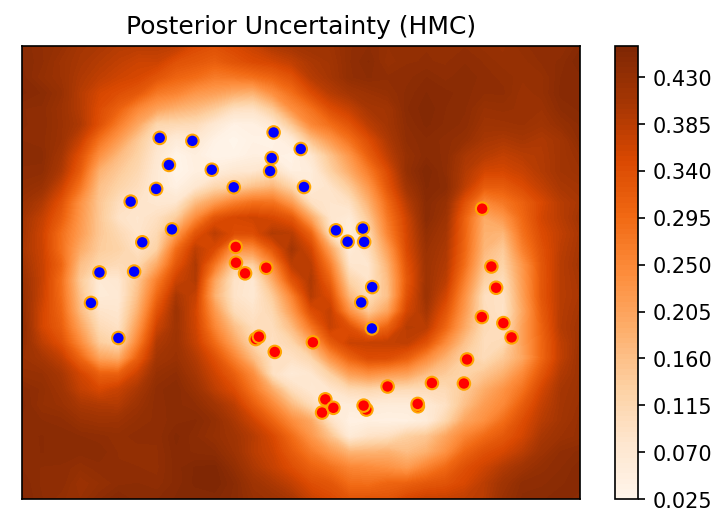

In [220]:
plt.contourf(x0, x1, sigmoid(p).std(0).reshape(x0.shape),
             101, cmap=plt.get_cmap('Oranges'))
plt.colorbar();
plot_data(X, y, edgecolors='orange');
plt.xticks([]); plt.yticks([]);
plt.title("Posterior Uncertainty ({})".format('HMC'));

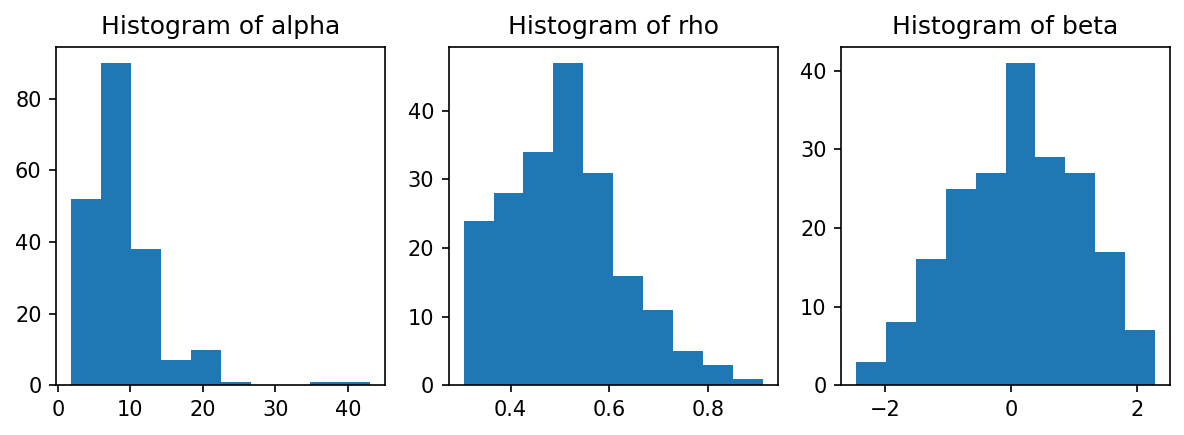

In [221]:
plt.figure(figsize=(8,3))
params = ['alpha', 'rho', 'beta']
for i in range(3):
    param = params[i]
    plt.subplot(1, 3, i+1)
    plt.hist(hmc_fit[param]); plt.title('Histogram of {}'.format(param))
plt.tight_layout()

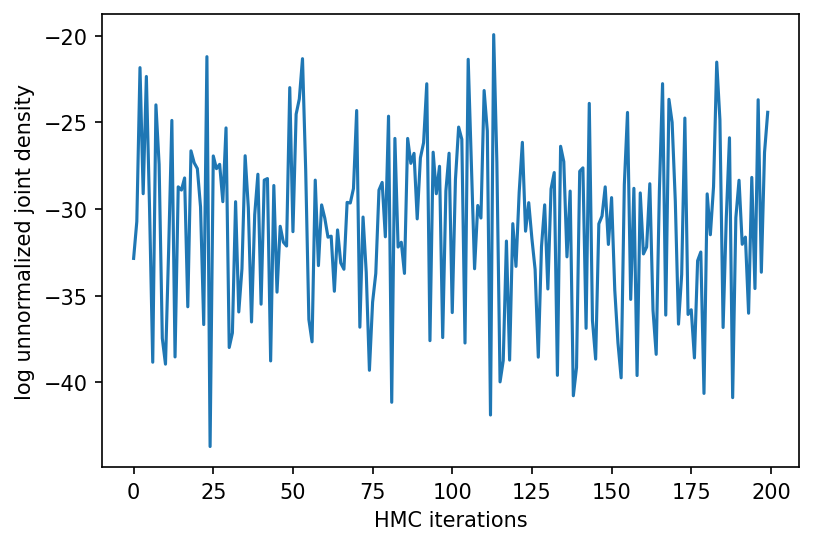

In [222]:
plt.plot(hmc_fit['lp__'])
plt.xlabel('HMC iterations')
plt.ylabel('log unnormalized joint density');